In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [46]:
def preprocess(text,pos=True,n_tags=None,filt=True,lower=False):
    """
    Input text string, return tokenized, postagged, filted tokens.
    """
    if filt:
        negative_tags = ['$',"''",'(',')','--','.',',',':','DT','CC','IN','TO']
        if n_tags:
            negative_tags.extend(n_tags)
    else:
        negative_tags = []
    
    if lower:
        text = text.lower()
        
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    filted_tokens = [(tok,pos) for (tok,pos) in tagged_tokens if pos not in negative_tags]
    
    if pos:
        return filted_tokens 
    else:
        return tokens
    
def mapidx(df,cat):
    
    c = Counter()
    
    for idx,row in df.iterrows():
        label = row[cat].split(',')
        c.update(label)
        
    keys = sorted(c.keys())
    mapidx = {key:idx for idx,key in enumerate(keys)}
    
    return mapidx

def data2feats(df,col=['CATS','WELLGOS']):
    
    d_idx = {colname:mapidx(df,colname) for colname in col}

    feats_col_n = sum([len(v) for k,v in d_idx.items()])
    
    feats = np.zeros([df.shape[0],feats_col_n])
    
    # Extend idx to fit feature col size
    for idx,colname in enumerate(col):
        if idx == 1:
            for k,v in d_idx[colname].items():
                d_idx[colname][k] += len(d_idx[col[idx-1]])
        if idx > 1:
            for k,v in d_idx[colname].items():
                d_idx[colname][k] += sum([len(d_idx[col[idx-(i+1)]]) for i in range(idx)])
    
    for idx,row in df.iterrows():
        for i,colname in enumerate(col):
            elements = row[colname].split(',')
            element_idxs = [d_idx[colname][e] for e in elements]
            for e_idx in element_idxs:
                feats[idx,e_idx] = 1
                
    return d_idx,feats
    
    
def getlabels(df,colname):
    
    c = Counter()
    for idx,row in df.iterrows():
        c.update(row[colname].split(','))
        
    keys = sorted(c.keys())
    d_idx = {k:i for i,k in enumerate(keys)}
    
    labels = np.zeros([df.shape[0]],dtype=int)
    
    for idx,row in df.iterrows():
        labels[idx] = d_idx[row[colname]]
        
    return d_idx,labels
    

def plotclusters(feats_2d,km_labels,df,legloc='lower left'):
    
    l_focus = df['FOCUS']
    l_names = df['N']
    l_gender = df['GENDER']
    
    fig,axes =plt.subplots(2,2, sharey=True,figsize=(16,16))
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    ax4 = axes[1,1]
    
    # KMeans Plot
    ax1.set_title('K Means')
    ax1.scatter(feats_2d[:,0],feats_2d[:,1],c=km_labels,s=50,linewidth=0.1,cmap='rainbow')
    
    # Other
    def plotrest(ax,name,lst):
        ax.set_title(name)
        label_added = []
        cmap = {l:c for l,c in zip(sorted(set(lst)),cm.rainbow(np.linspace(0,0.9,len(set(lst)))))}
        colors = [cmap[l] for l in lst]
        for i,c in enumerate(colors):
            x = feats_2d[i,0]
            y = feats_2d[i,1]
            l = lst[i]
            if l not in label_added:
                ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)
                label_added.append(l)
            else:
                ax.scatter(x, y, s=50, linewidth=0.1, c=c)
        ax.legend(loc=legloc)
        
    plotrest(ax2,'FOCUS',l_focus)
    plotrest(ax3,'NAME',l_names)
    plotrest(ax4,'GENDER',l_gender)

In [3]:
df = pd.read_csv('GenderEven207.csv')
df['TOKENS'] = None

for idx,row in df.iterrows():
    row['TOKENS'] = preprocess(row['RAW'],pos=False)

In [4]:
df

,RAW,CATS,WELLGOS,FOCUS,N,GENDER,TOKENS
0,"Throughout my drinking career, instant gratifi...","PROGRESS / start small,INNER MASTERY / take a ...","Baby Step Embracer,Finish Line Forgetter,The M...",DRUGS/ALC,Paul,male,"[Throughout, my, drinking, career, ,, instant,..."
1,I tried to control every aspect of my life. Wh...,"CONTROL,SERENITY,FREEDOM / past & let go,TRUST...","Controller Coaster,Should Shover,Serenity Simu...",DRUGS/ALC,Paul,male,"[I, tried, to, control, every, aspect, of, my,..."
2,Thinking about drinking – the taste and feel –...,"CRAVINGS / will power & tools,INNER POWER / Se...","Pattern Interrupter,New Pattern Painter,Craver...",DRUGS/ALC,Paul,male,"[Thinking, about, drinking, –, the, taste, and..."
3,I always thought today/this weekend/this week ...,"DELUSION,CONFESSION / denial,TRUTH / self honesty","Delusion Detector,Sabotage SOS’r,Insanity SOS’...",DRUGS/ALC,Paul,male,"[I, always, thought, today/this, weekend/this,..."
4,The people around me only saw what I wanted th...,"CONFIDENCE / acceptance & worth,DELUSION,VULNE...","Self Esteem Elixir,Confidence Caffeinator,Inne...",DRUGS/ALC,Paul,male,"[The, people, around, me, only, saw, what, I, ..."
5,Resigned to the fact that being poor or homele...,"CONFIDENCE / hope & future,FREEDOM / past & l...","Excuse Exterminator,Rationalization Rinser,Gra...",DRUGS/ALC,Paul,male,"[Resigned, to, the, fact, that, being, poor, o..."
6,"Alcohol was great for two things, suppressing ...","WORTHINESS / connections & sharing,VULNERABILI...","Emotions Engineer,Feelings Fantasizer,Compassi...",DRUGS/ALC,Paul,male,"[Alcohol, was, great, for, two, things, ,, sup..."
7,I’ve started more things than I can count and ...,"COMMITMENTS,MOTIVATION,RESPONSIBILITY,INNER PO...","Finish Line Forgetter,The Procrastina-shunner,...",DRUGS/ALC,Paul,male,"[I’ve, started, more, things, than, I, can, co..."
8,How great it was to have a friend that I could...,"EGO,PRIDE ,INFLUENCES,COMMUNITY / healthy rela...","Foul Weather Friender,Arrogance Arrestor,Pride...",DRUGS/ALC,Paul,male,"[How, great, it, was, to, have, a, friend, tha..."
9,Diving headlong into whatever had caught my in...,"COMMITMENTS,PROGRESS / start small,INNER POWER...","Symbolic Stepper,New Pattern Painter / grit & ...",DRUGS/ALC,Paul,male,"[Diving, headlong, into, whatever, had, caught..."


# ONLY CATS

Feats Shape:  (414, 200)
Included:  dict_keys(['CATS'])


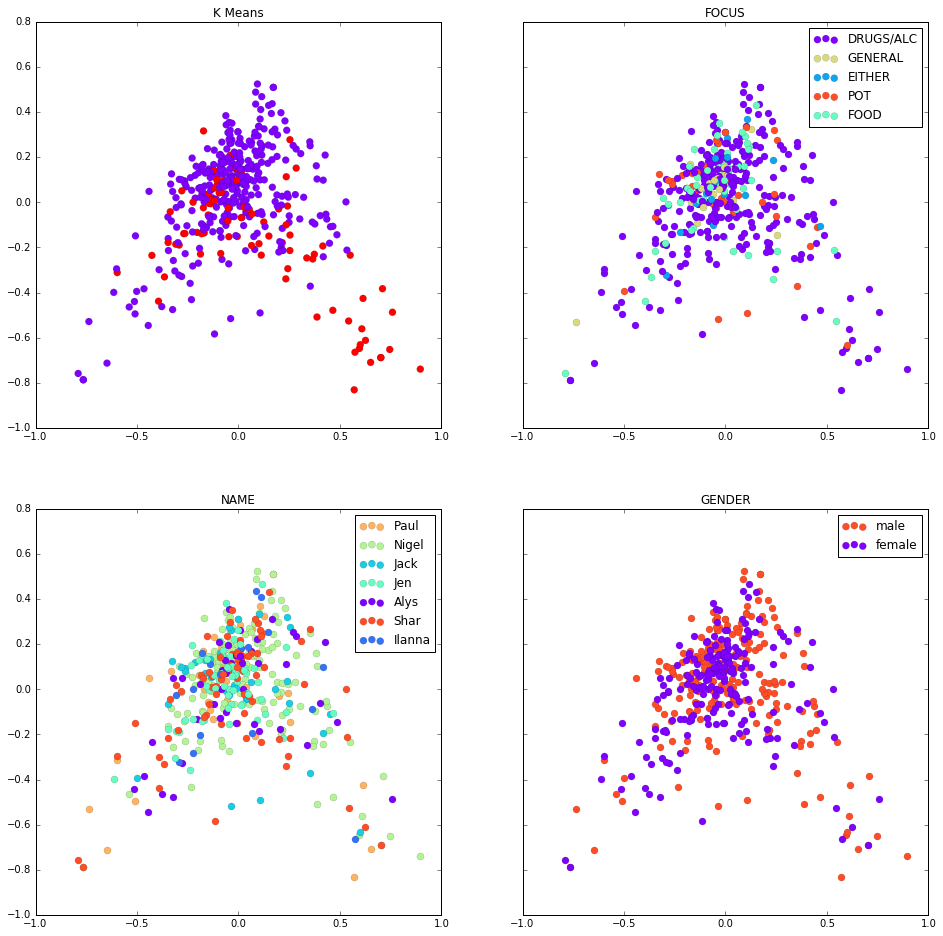

In [55]:
d_idx,feats = data2feats(df,col=['CATS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=2)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

No clear pattern if looking at only categories.

# CATS vs FOCUS

Feats Shape:  (414, 205)
Included:  dict_keys(['FOCUS', 'CATS'])


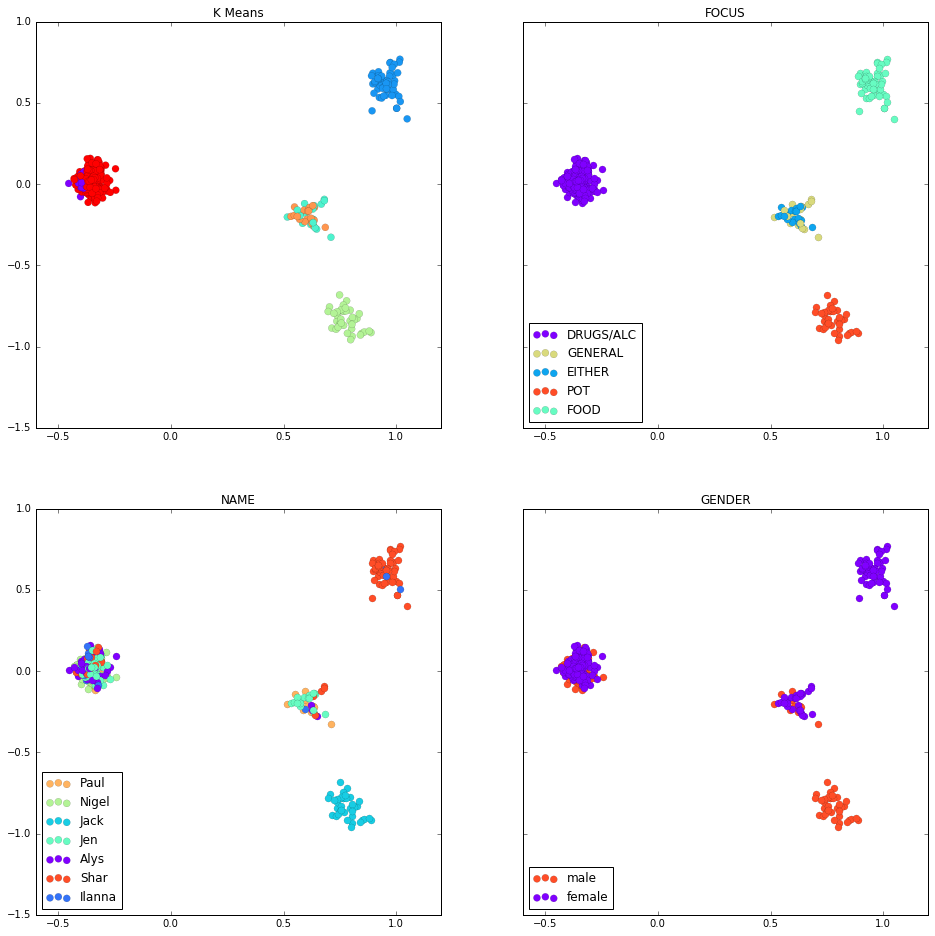

In [65]:
d_idx,feats = data2feats(df,col=['CATS','FOCUS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=6)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='lower left')

1. Categories are strongly related to focus.
2. Categories for FOOD(mostly female) are similar.
3. Categories for POT(mostly male) are similar.

# CATS vs N

Feats Shape:  (414, 207)
Included:  dict_keys(['N', 'CATS'])


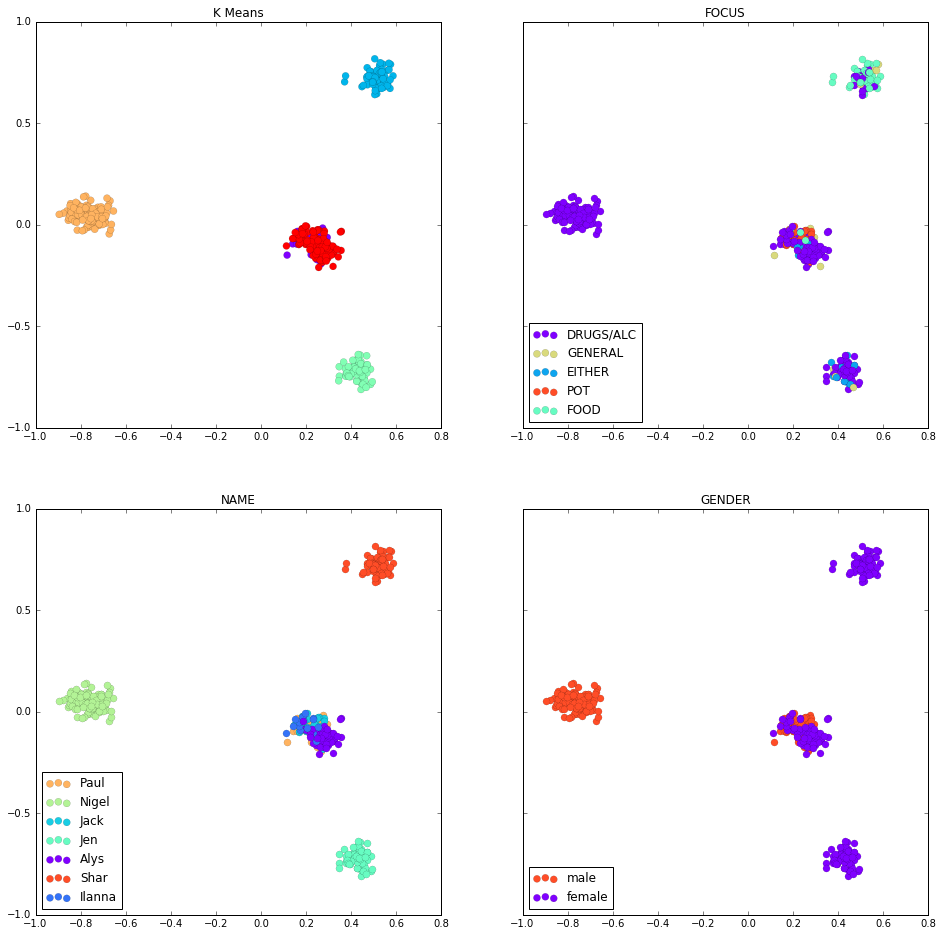

In [67]:
d_idx,feats = data2feats(df,col=['CATS','N'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=5)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='lower left')

Red Cluster in KMeans: Paul,Alys,Ilanna,Jack share similar categories? Deeper look required.

# CAT vs GENDER

Feats Shape:  (414, 202)
Included:  dict_keys(['GENDER', 'CATS'])


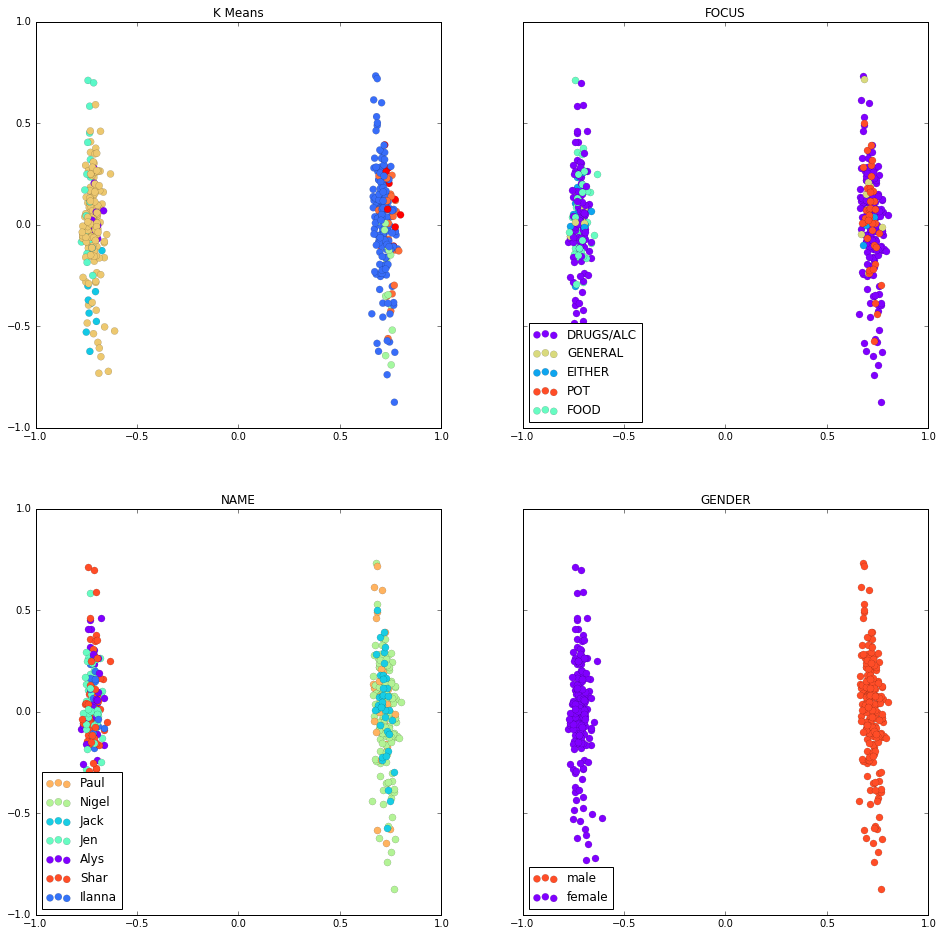

In [76]:
d_idx,feats = data2feats(df,col=['CATS','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=8)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='lower left')

Some similar categories in each gender: light blue & yellow cluster in KMeans. Chek what are those categories.

# ONLY WELLGOS

Feats Shape:  (414, 402)
Included:  dict_keys(['WELLGOS'])


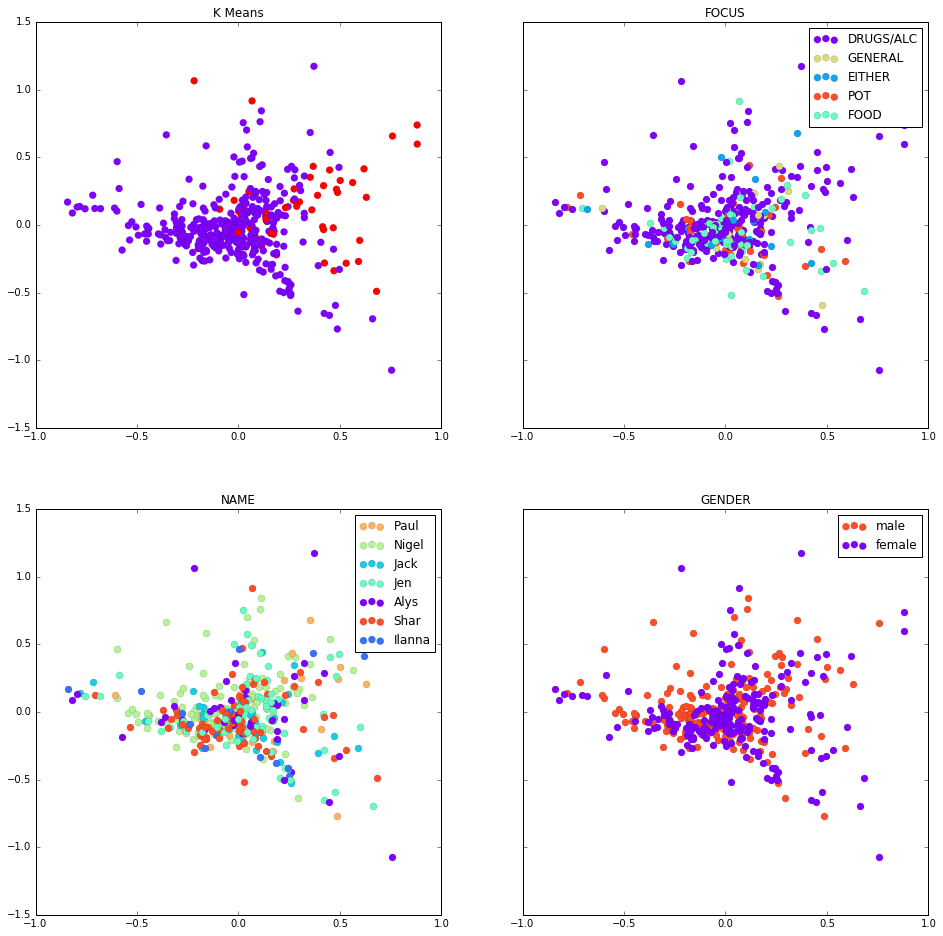

In [14]:
d_idx,feats = data2feats(df,col=['WELLGOS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=2)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df)

No clear pattern if only looking at wellgorithms.

# WELLGOS vs CATS

Feats Shape:  (414, 602)
Included:  dict_keys(['WELLGOS', 'CATS'])


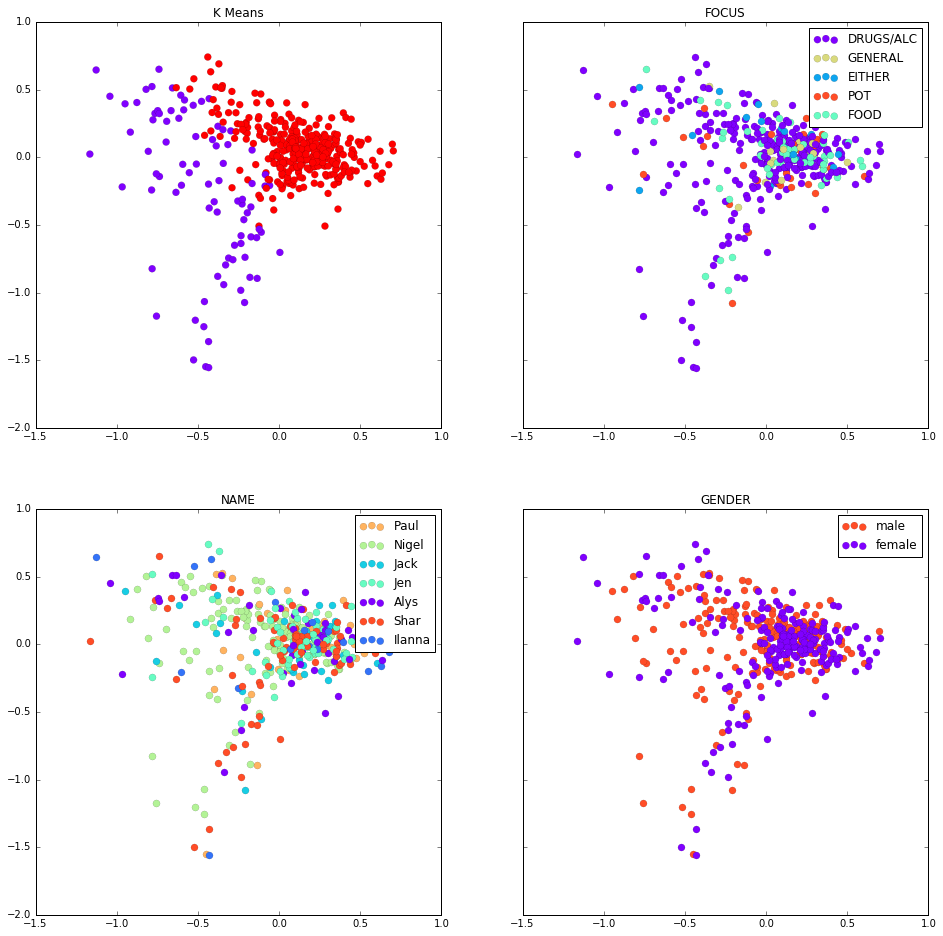

In [18]:
d_idx,feats = data2feats(df,col=['CATS','WELLGOS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=2)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df)

Some overlapping in terms of categories and wellgorithms choosen, perhaps commonly combined categories and wellgorithms or most choosen ones. Deeper investigation required.

# WELLGOS vs FOCUS

Feats Shape:  (414, 407)
Included:  dict_keys(['FOCUS', 'WELLGOS'])


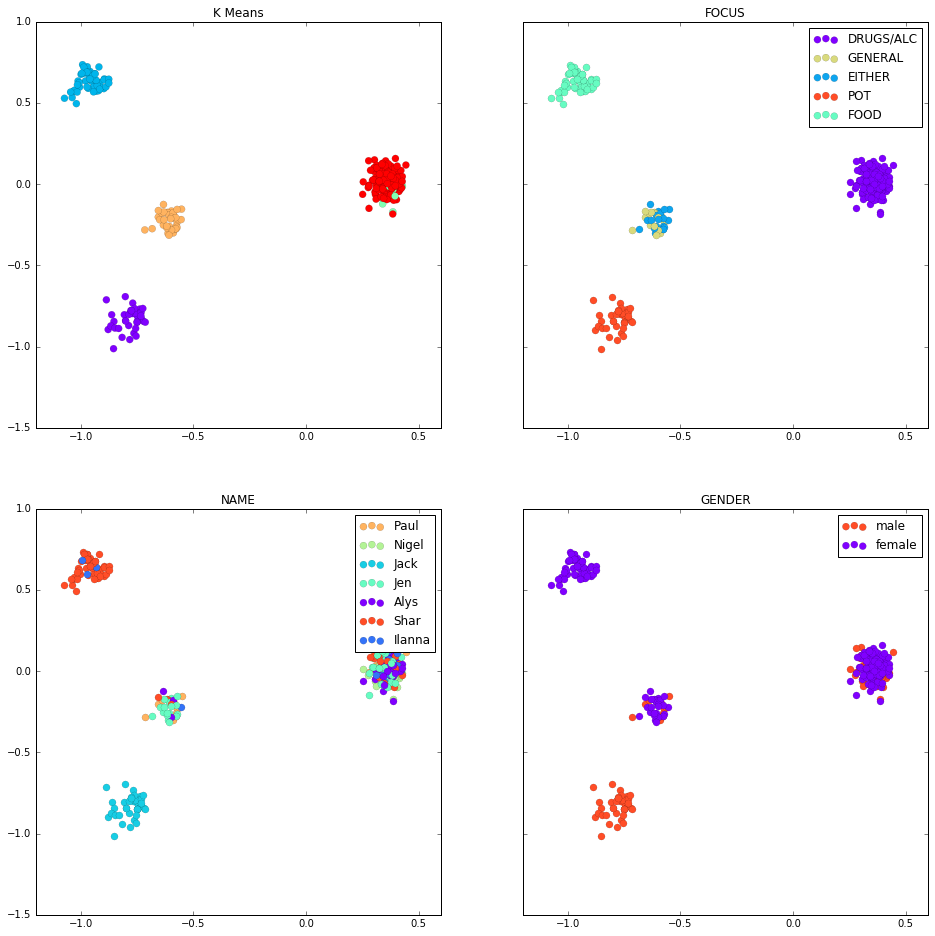

In [72]:
d_idx,feats = data2feats(df,col=['WELLGOS','FOCUS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=5)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Wellgorithms are strongly related to focuses as well

# WELLGOS vs N

Feats Shape:  (414, 409)
Included:  dict_keys(['N', 'WELLGOS'])


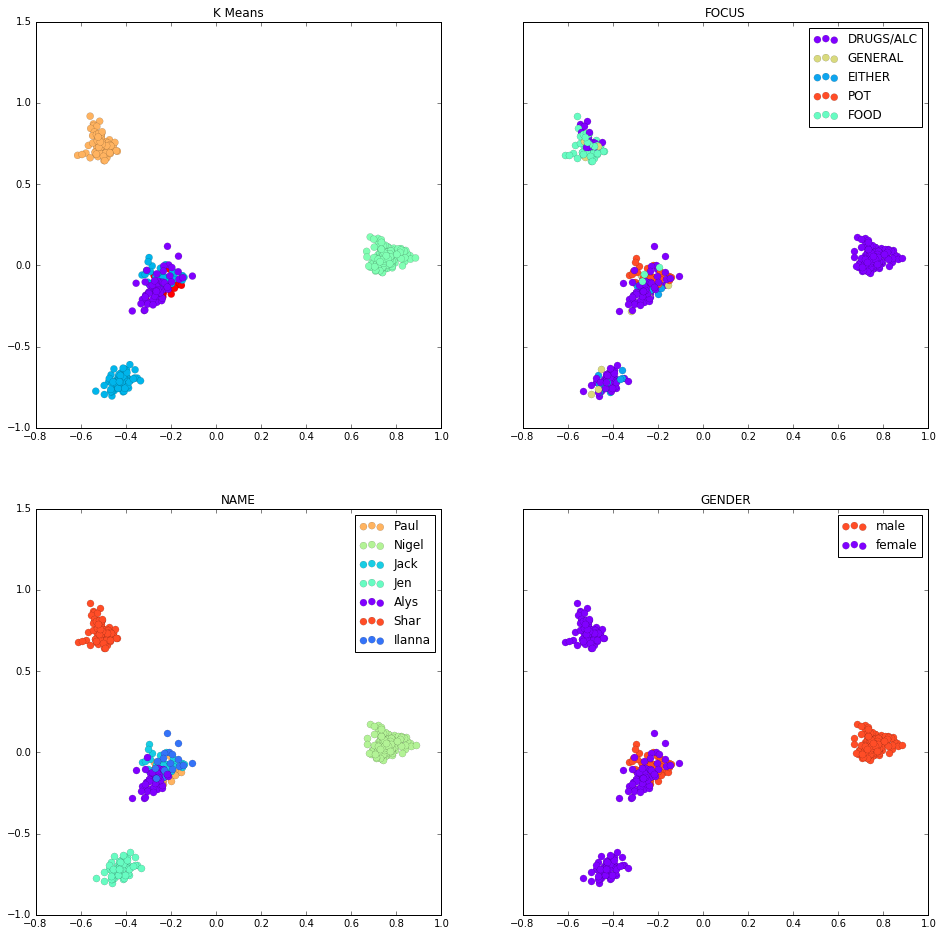

In [73]:
d_idx,feats = data2feats(df,col=['WELLGOS','N'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=5)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Wellgorithms are strongly related to NAMEs.

# WELLGOS vs GENDER

Feats Shape:  (414, 404)
Included:  dict_keys(['WELLGOS', 'GENDER'])


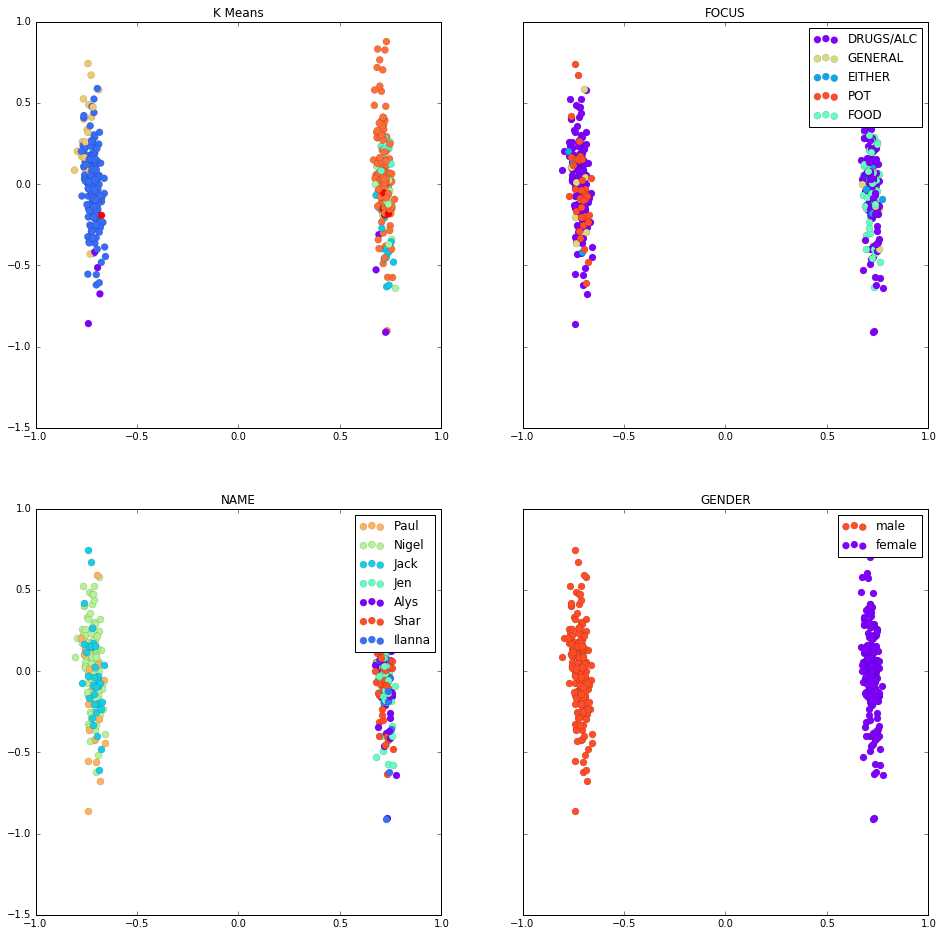

In [75]:
d_idx,feats = data2feats(df,col=['WELLGOS','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=8)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

Some similar wellgorithms in each gender: light blue & yellow cluster in KMeans.

# CATS + WELLGOS + FOCUS

Feats Shape:  (414, 607)
Included:  dict_keys(['FOCUS', 'WELLGOS', 'CATS'])


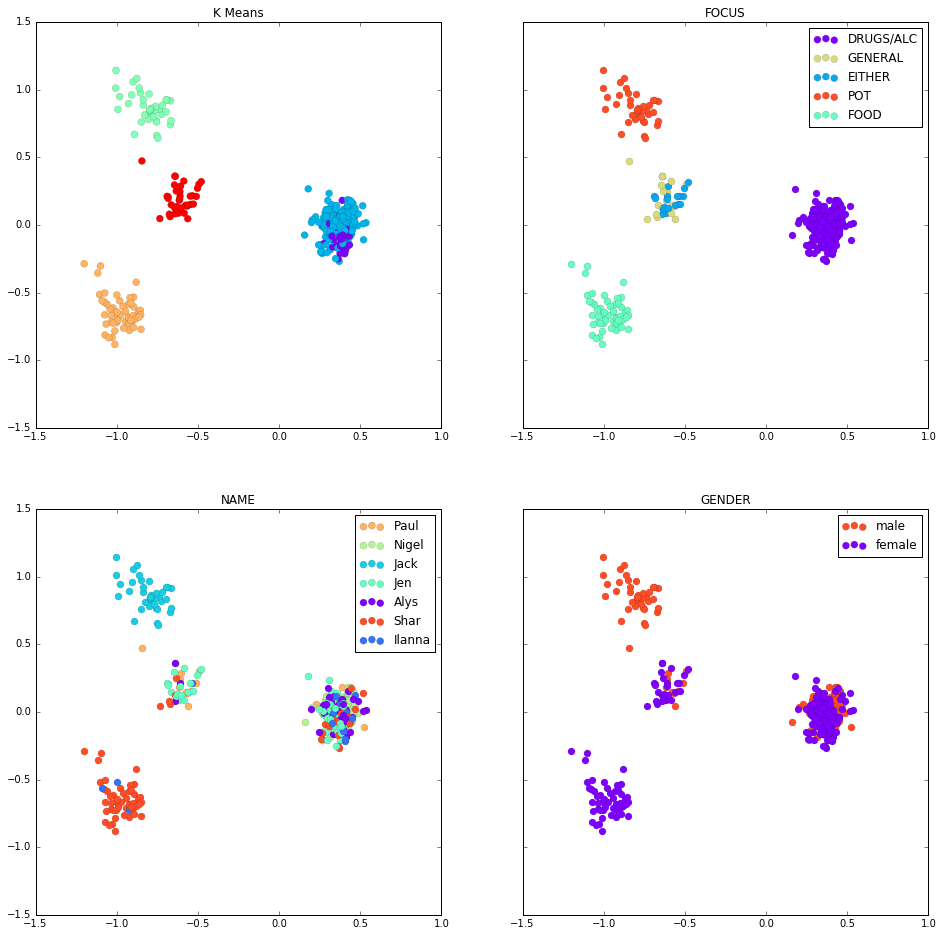

In [48]:
d_idx,feats = data2feats(df,col=['CATS','WELLGOS','FOCUS'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=5)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

1. FOOD are almost all females
2. POT are almost all males
3. Jack likes POT
4. Shar likes FOOD and DRUGS/ALC

# CATS + WELLGOS + FOCUS + NAME

Feats Shape:  (414, 614)
Included:  dict_keys(['N', 'FOCUS', 'WELLGOS', 'CATS'])


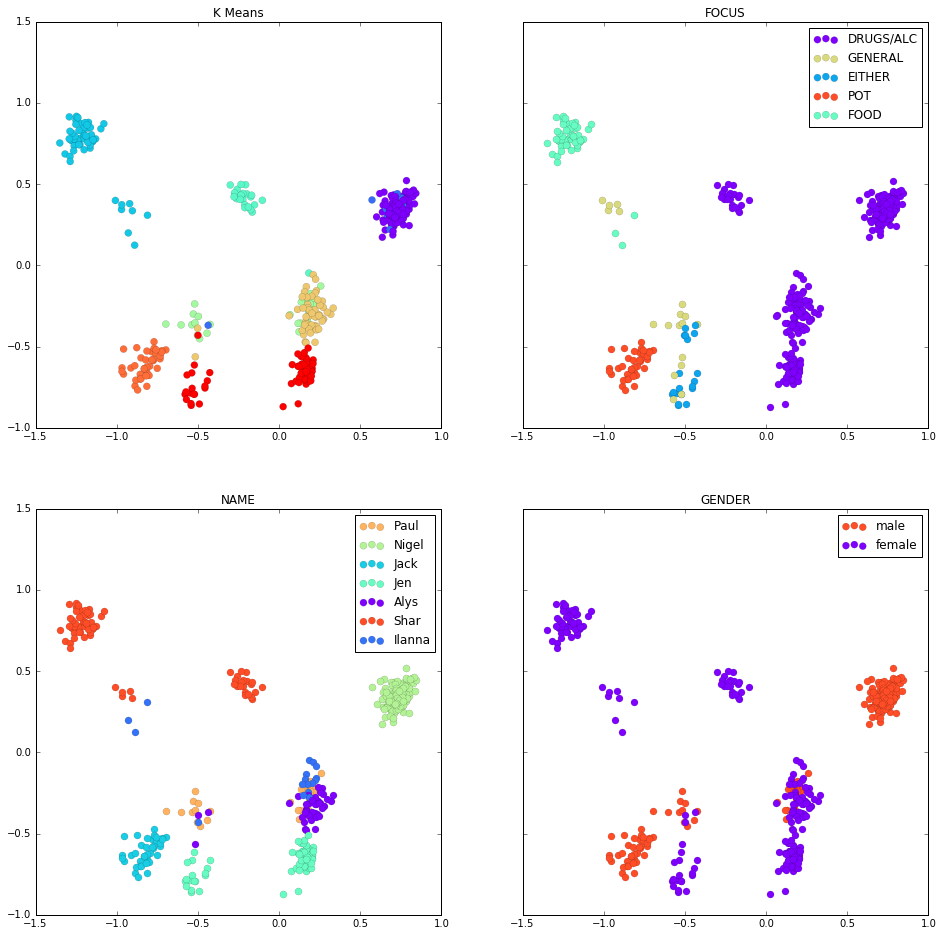

In [52]:
d_idx,feats = data2feats(df,col=['CATS','WELLGOS','FOCUS','N'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=8)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='upper right')

1. Name fits gender, obviously
2. Nigel likes DRUGS/ALC
3. Jen likes DRUGS/ALC
4. Allys likes DRUGS/ALC
5. Paul is complex, between DRUGS/ALC, GENERAL, EITHER

# CATS + WELLGOS + FOCUS + GENDER

Feats Shape:  (414, 609)
Included:  dict_keys(['FOCUS', 'WELLGOS', 'GENDER', 'CATS'])


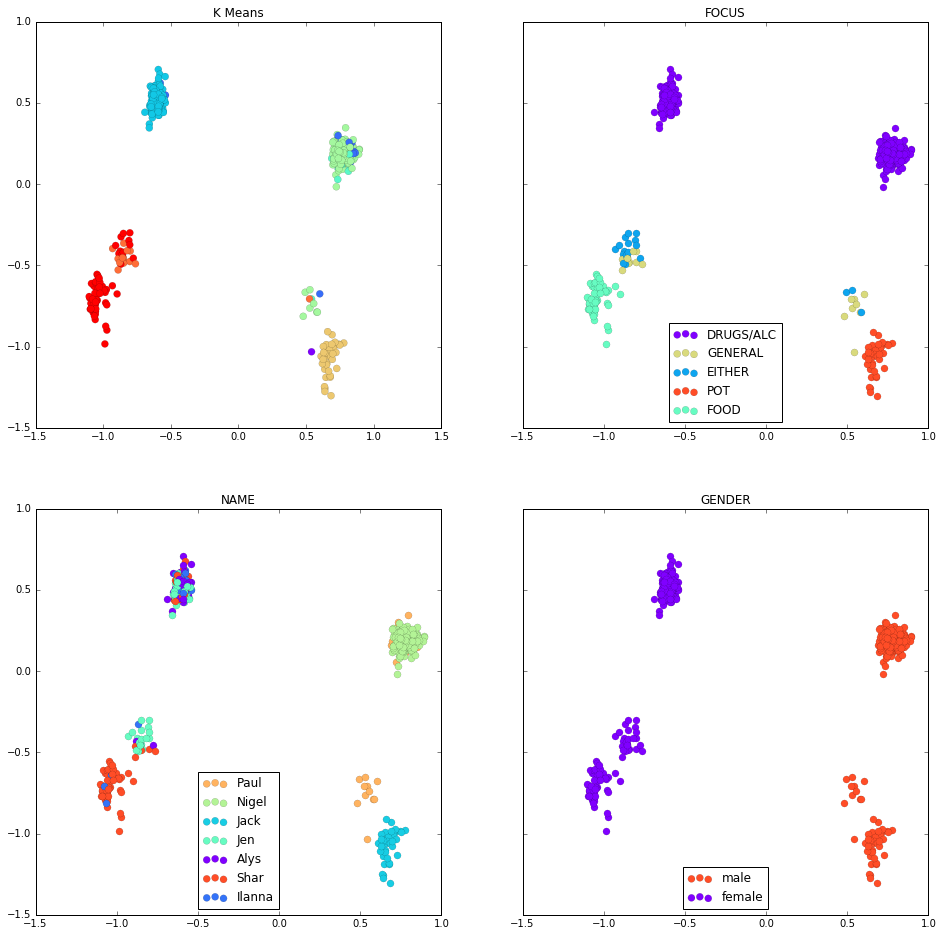

In [59]:
d_idx,feats = data2feats(df,col=['CATS','WELLGOS','FOCUS','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=8)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df,legloc='lower center')

male/female+FOOD close to male/female+EITHER+GENERAL, common categories or wellgorithms perhaps, further look required.


# CATS + WELLGOS + FOCUS + NAME + GENDER

Feats Shape:  (414, 616)
Included:  dict_keys(['N', 'FOCUS', 'WELLGOS', 'GENDER', 'CATS'])


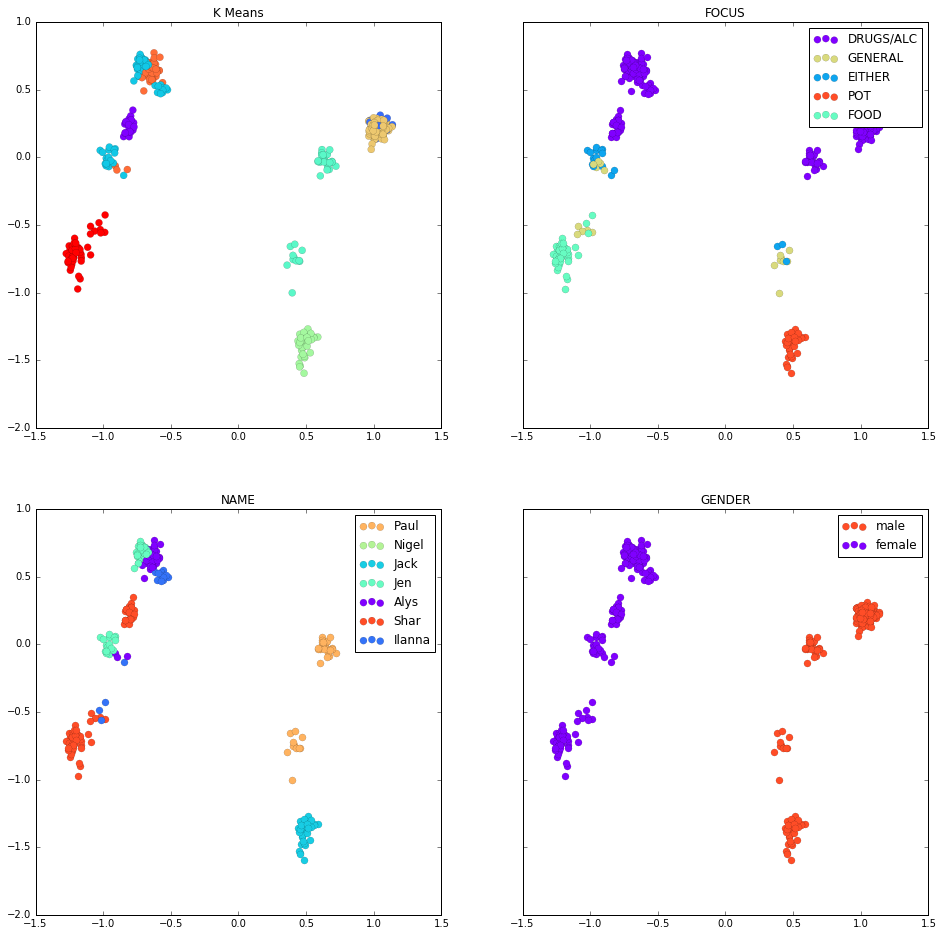

In [31]:
d_idx,feats = data2feats(df,col=['CATS','WELLGOS','FOCUS','N','GENDER'])

print('Feats Shape: ', feats.shape)
print('Included: ', d_idx.keys())

pca = PCA(n_components=2)
feats_2d = pca.fit_transform(feats)

kmeans = KMeans(n_clusters=8)
kmeans.fit(feats)

plotclusters(feats_2d,kmeans.labels_,df)